In [1]:
#用来算反射位置的程序
import time
import sys
sys.path.append("..")
from MTRT import *
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from LGSM import LGSM
from datetime import datetime
from DEORtool import DEOR_tool as dt
from DEORtool import EoRmod
from DEORtool import DEOR_simulation
from cbeam import cbeam
from MTRT import Bv
import csv
from IPython.display import Latex
from scipy.interpolate import interp1d
from matplotlib import cm

Meteor start point coords:  40.951625115102296 39.80557109226519
Meteor end point coords:  36.97432181323711 100.33595129669784


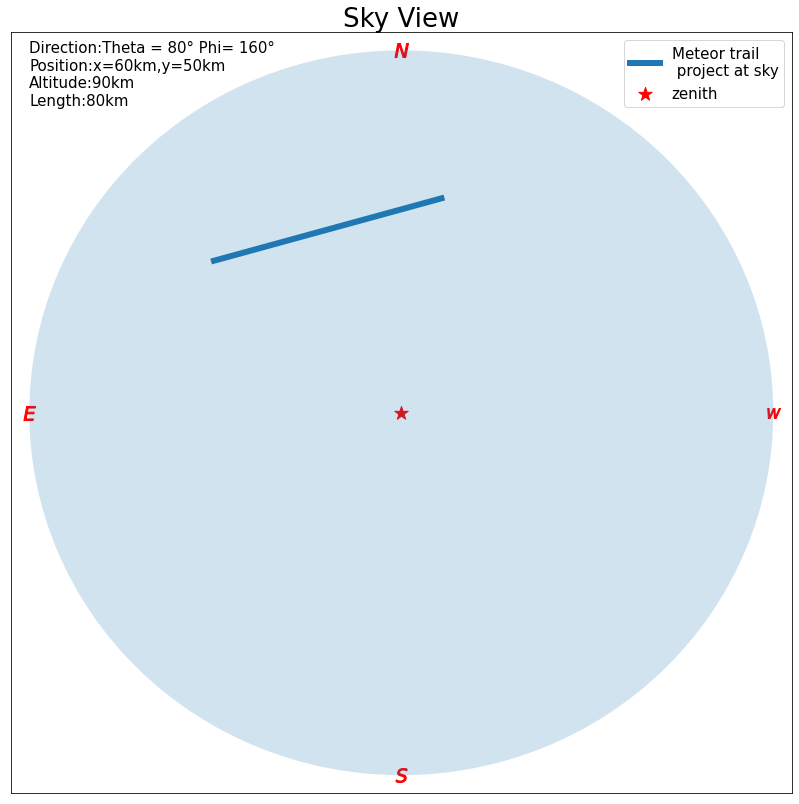

In [2]:
# 设置流星参数，流星方向向量
#dataset 1  80 160 60 50 90 80
#dataset 2  80 160 60 50 90 40
#dataset 3  80 160 10 50 90 80
#dataset 4  80 160 60 10 90 80

#dataset 5  60 20   30  80 90 60
#dataset 6  75 135 -45 -30 80 40
#dataset 7  30 240  60 -55 90 50
#dataset 8  45 300  55  75 100 80
mt_theta = 80 #天顶距
mt_phi = 160 #方位角
# 距离坐标单位为km
mt_origin = [60,50,90]
Length = 80
mt = MeteorTrail(mt_origin,mt_theta,mt_phi,length=Length)
Mm = mt.get_zvector()
#print(Mm)
wl_origin = mt.trans_origin()
#print(wl_origin)
Mt_position = mt.end
Mt_RP = (np.array(mt_origin)+Mt_position)/2
#print("Meteor cenetr to origin: ",Mt_RP)
# 流星中点到原点的距离，用于计算功率
Mt_R = np.dot(Mt_RP,Mt_RP)**0.5*1000
#print(Mt_R)
#print(Mt_position)
# 得到local坐标系的基
localx,localy,localz = getwl(Mm,mt_origin)
#print(localx,localy,localz)

mtheta,mphi = MTvec2ang(mt_origin[0],mt_origin[1],mt_origin[2])
print("Meteor start point coords: ",mtheta*180/np.pi,mphi*180/np.pi)
Mtheta,Mphi = MTvec2ang(Mt_position[0],Mt_position[1],Mt_position[2])
print("Meteor end point coords: ",Mtheta*180/np.pi,Mphi*180/np.pi)

# m是流星原点，M是流星终点
# mx，my是流星原点在天球圆投影坐标， Mx，My同理
mx = -np.sin(mtheta)*np.cos(mphi)
Mx = -np.sin(Mtheta)*np.cos(Mphi)

my = np.sin(mtheta)*np.sin(mphi)
My = np.sin(Mtheta)*np.sin(Mphi)
# 由于使用单位圆作为天球，x，y值而不是弧度表示天球上的位置，因此与真实位置有一点差异，
# 比如theta=30,phi=0应该出现在【1/3,0】的位置上，但是按照我的算法是在【1/2,0】的位置上。
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
cir1 = plt.Circle(xy=(0.0,0.0),radius=1,alpha=0.2)

markers = ["$N$","$S$","$W$","$E$"]

plt.scatter(0,0,marker="*",color="r",s=200,label="zenith")
plt.scatter(0,1,marker=markers[0],color="r",s=200)
plt.scatter(0,-1,marker=markers[1],color="r",s=200)
plt.scatter(1,0,marker=markers[2],color="r",s=200)
plt.scatter(-1,0,marker=markers[3],color="r",s=200)
plt.text(-1,0.85,'Direction:Theta = %d° Phi= %d°\nPosition:x=%dkm,y=%dkm\nAltitude:%dkm\nLength:%dkm'%(mt_theta,mt_phi,mt_origin[0],mt_origin[1],mt_origin[2],Length),fontsize=15)

#plt.scatter(y,-x,c='y',s=20,label="covered sky")
plt.plot([mx,Mx],[my,My],linewidth=6,label="Meteor trail\n project at sky")

plt.xlim(-1.05,1.05)
plt.ylim(-1.05,1.05)

plt.xticks([])
plt.yticks([])

ax.add_patch(cir1)
plt.legend(fontsize=15,loc='best')
plt.title("Sky View",fontsize=26)

#file_name = "meteor_pos-xyz_"+str(op) + "-theta_phi-"+str(mt_theta)+"_"+str(mt_phi)
#plt.savefig("/home/jiomer/Documents/pygdsm/DEoRtool/meteor_fig/"+file_name+".png",dpi=200)
plt.show()

In [3]:
# 发射光线，istheta，isphi记录了可以被反射的ray的方向
# 建议先在全天用0.1的分辨率扫一遍然后用更小的范围更高的精度计算反射天区
T1 = time.time()
delang=0.005
ray_theta = np.arange(34,41,delang)
ray_phi = np.arange(39.5,101,delang)
lx,ly,lz = getwl(Mm,mt_origin)
print(lx,ly,lz)
ist = []
isp = []
# 被反射光线覆盖到的天区坐标
thetal = []
phil = []
for i in ray_theta:
    for j in ray_phi:
        ray = Ray(i,j)
        rv = ray.rayvectors()
        tsrv = get_trans(rv,lx,ly,lz)
        blv,nv = mt.return_nvector(tsrv,wl_origin)
        if blv == True:
            refv = reflection(tsrv,nv)
            tsrefv = get_trans(refv,lx,ly,lz,ws2wl=False)
            skytheta,skyphi = vec2ang(tsrefv[0],tsrefv[1],tsrefv[2])
            # 如果指向底面（theta大于0.5pi)就扔掉
            if skytheta < 0.5*np.pi:
                ist.append(i)
                isp.append(j)
                thetal.append(skytheta)
                phil.append(skyphi)
            else:
                pass
        else:
            pass
T2 = time.time()
print('耗费时间:%s 秒'%(T2-T1))
print(f"min theta is {min(ist)}, min phi is {min(isp)}")
print(f"max theta is {max(ist)}, max phi is {max(isp)}")
thetal = np.array(thetal)
phil = np.array(phil)

[-0.33071077 -0.49409443 -0.80405291] [-0.18502579 -0.80151121  0.56863453] [-0.92541658  0.33682409  0.17364818]
耗费时间:777.0006358623505 秒
min theta is 34.63000000000032, min phi is 39.79000000000015
max theta is 40.97500000000357, max phi is 100.33500000003113


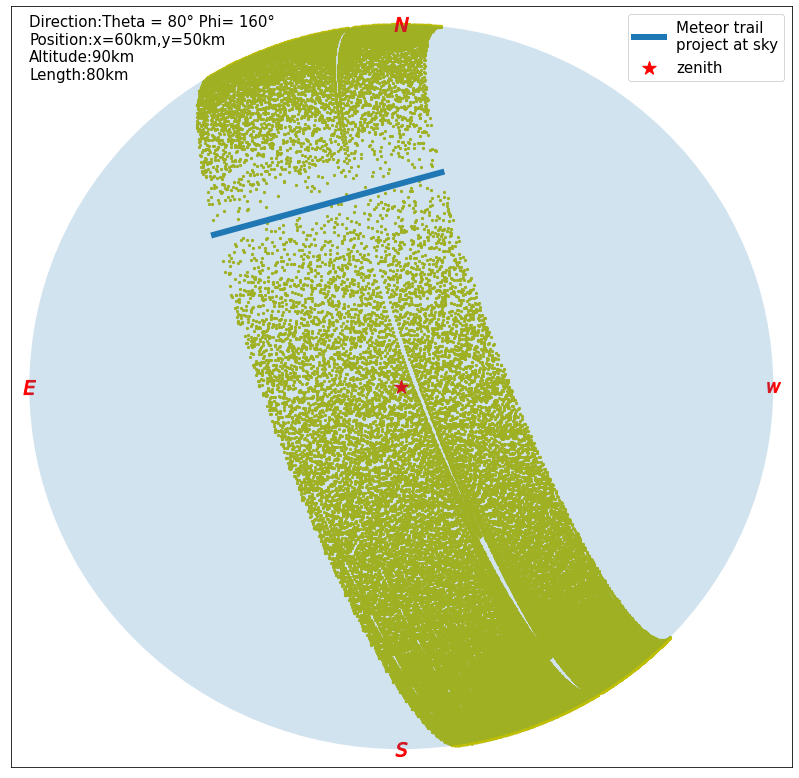

In [4]:
x = -np.sin(thetal)*np.cos(phil)
y = np.sin(thetal)*np.sin(phil)
z = np.cos(thetal)

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
cir1 = plt.Circle(xy=(0.0,0.0),radius=1,alpha=0.2)

markers = ["$N$","$S$","$W$","$E$"]

plt.text(-1,0.85,'Direction:Theta = %d° Phi= %d°\nPosition:x=%dkm,y=%dkm\nAltitude:%dkm\nLength:%dkm'%(mt_theta,mt_phi,mt_origin[0],mt_origin[1],mt_origin[2],Length),fontsize=15)
plt.scatter(x,y,c='y',s=5)

plt.scatter(0,0,marker="*",color="r",s=200,label="zenith")
plt.scatter(0,1,marker=markers[0],color="r",s=200)
plt.scatter(0,-1,marker=markers[1],color="r",s=200)
plt.scatter(1,0,marker=markers[2],color="r",s=200)
plt.scatter(-1,0,marker=markers[3],color="r",s=200)

plt.plot([mx,Mx],[my,My],linewidth=6,label="Meteor trail\nproject at sky")

plt.xlim(-1.05,1.05)
plt.ylim(-1.05,1.05)

plt.xticks([])
plt.yticks([])

ax.add_patch(cir1)
plt.legend(fontsize=15,loc='best')

plt.show()

In [5]:
NSIDE = 2**9
res_ang= hp.nside2resol(NSIDE, arcmin=True) / 60
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, res_ang
    )
)

NPIX = hp.nside2npix(NSIDE)
print(f"NPIX is: {NPIX}.")

m = 0*np.ones( (1,NPIX) )[0]
positions = []
for i in range(len(x)):
    ipix_disc = hp.query_disc(nside=NSIDE, vec=np.array([z[i],-x[i],y[i]]), radius=np.radians(1.5) )
    positions.extend(ipix_disc)
    m[ipix_disc] = 1

positions = np.unique(positions)

Approximate resolution at NSIDE 512 is 0.11 deg
NPIX is: 3145728.


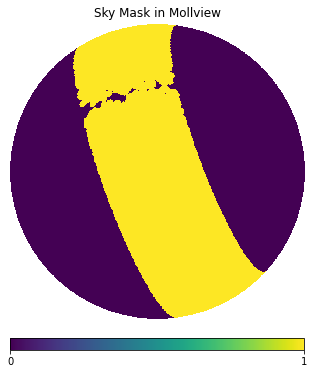

In [6]:
t, p =dt.hp2az(NSIDE)
vec = hp.ang2vec(np.pi/2,0)
ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(90))
theta1 = 0*np.ones( (1,NPIX) )[0]
phi1 = 0*np.ones( (1,NPIX) )[0]
#n = 0*np.ones( (1,NPIX) )[0]
theta1[ipix_disc] = t
phi1[ipix_disc] = p
theta_ql = theta1[positions]
phi_ql = phi1[positions]
#n[positions] = phi_ql
#hp.orthview(phi1,half_sky=True, title="Sky Mask in Mollview")
#hp.orthview(n2, half_sky=True, title="Sky Mask in Mollview")
#hp.orthview(n3, half_sky=True, title="Sky Mask in Mollview")
hp.orthview(m, half_sky=True, title="Sky Mask in Mollview")

In [7]:
head = ['theta','phi','d1','d2','Height','Length']
head1 = [mt_theta,mt_phi,mt_origin[0],mt_origin[1],mt_origin[2],Length]

In [8]:
with open("data1.csv","w") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(head)
    writer.writerow(head1)
    writer.writerows([theta_ql,phi_ql,m,positions])